# **Implementacion de modelos de regresion**

In [1]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA


from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from scipy.stats import jarque_bera

## ***Metodología***

En este seccioón se implementaran 4 modelos, 3 de ellos modelos tradicionales de Machine Learning y el cuarto es un modelo híbrido entre XGboost y SVR, durante toda la implementación se iran comentando los resultados, los cuales nos llevaran a llegar a distintas conclusione.

Para cada uno de los modelos tradicionales se realizó su respectiva hiperparametrización, además de variar el tamaño de datos que seran tomados para predecir la variable respuesta, a estos tamaños se les llamaran ventanas, siendo esta de 7,14,21 y 28 días, se escogerá la ventana que ofrece el mejor score en el conjunto de test. Luego de hallar los 3 mejores modelos, estos serán tomados para ser comparados con los resultados del modelo original propuesto

In [2]:
data_pm10=pd.read_csv("C:/Users/fonta/OneDrive/Documentos/CDD/6. Sexto semestre/Machine learning/Proyecto final/seriepm10.csv")

In [3]:
data_pm10.head()

,fecha,pm10
0,2017-01-01 00:59:59+00:00,61.9
1,2017-01-01 01:59:59+00:00,101.0
2,2017-01-01 02:59:59+00:00,75.6
3,2017-01-01 03:59:59+00:00,56.3
4,2017-01-01 04:59:59+00:00,107.1


In [4]:
def makeXy(ts, nb_timesteps):
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        #if i-nb_timesteps <= 4:
            #print(i-nb_timesteps, i-1, i)
        X.append(list(ts.loc[i-nb_timesteps:i-1])) #Regressors
        y.append(ts.loc[i]) #Target
    X, y = np.array(X), np.array(y)
    return X, y

## **Random Forest**

Veamos la implementación y el rendimiento que tiene el modelo Random Forest para los datos de la serie de tiempo de la estación Ermita en la ciudad de Cali.

In [ ]:
resultados_rf = {}

for i in [7 * 24, 14 * 24, 21 * 24, 28 * 24]:
    nb_timesteps = i
    X, y = makeXy(data_pm10['pm10'], nb_timesteps)

    train_size = int(len(X) * 0.6)  
    val_size = int(len(X) * 0.2)    

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    param_grid = {
        'n_estimators': [50, 100, 150], 
        'max_depth': [5, 10, 20]   
    }

    best_score = -np.inf
    best_params = None
    best_model_rf = None

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:

            pipeline = Pipeline([
                ('scaler', StandardScaler()), 
                ('rf', RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    n_jobs=-1 
                ))
            ])

            pipeline.fit(X_train, y_train)

            y_val_pred = pipeline.predict(X_val)
            score = r2_score(y_val, y_val_pred)
            print(f"n_estimators={n_estimators}, max_depth={max_depth}" f"R2 en validación: {score}")

            if score > best_score:
                best_score = score
                best_params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                }
                best_model_rf = pipeline

    y_test_pred = best_model_rf.predict(X_test)

    resultados_rf[i] = {
        'parametros': best_params,
        'score val': best_score,
        'score test': r2_score(y_test, y_test_pred),
        'residuos': y_test - y_test_pred,
        'predicc': y_test_pred,
        'modelo': best_model_rf,
        'entrenamiento y': y_train,
        'observado': y_test
    }

In [5]:
with open('resultados_rf.pkl', 'rb') as f:
    Random = pickle.load(f)

### **Métricas y errores**

In [6]:
tabla1 = pd.DataFrame()

for clave, valor in Random.items():
    real = valor['observado']
    predic = valor['predicc']
    residuos=valor['residuos']
    r2=valor['score test']
    parametro=valor['parametros']
    
    # Calcular las métricas
    mae = mean_absolute_error(real, predic)
    mse = mean_squared_error(real, predic)
    rmse = np.sqrt(mse)

    ljung_box_results = acorr_ljungbox(residuos, lags=[10], return_df=True)
    
    jb_stat, jb_pvalue = jarque_bera(residuos)
    
    tabla_temp = pd.DataFrame({
        'Ventana': [clave],
        'parametro': [parametro],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse],
        'R2': [r2],
        'Ljung-Box p-value': [ljung_box_results['lb_pvalue'].values[0]],
        'Jarque-Bera p-value': [jb_pvalue]
    })
    
    tabla1 = pd.concat([tabla1, tabla_temp], ignore_index=True)

# Mostrar el DataFrame final
tabla1

,Ventana,parametro,MAE,MSE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,168,"{'n_estimators': 150, 'max_depth': 20}",9.323569,178.558666,13.362585,0.556085,0.004796,0.0
1,336,"{'n_estimators': 150, 'max_depth': 20}",9.340586,178.054768,13.343716,0.557930,0.000243,0.0
2,504,"{'n_estimators': 150, 'max_depth': 20}",9.366953,179.127912,13.383868,0.556033,0.001116,0.0
3,672,"{'n_estimators': 150, 'max_depth': 20}",9.416496,180.187918,13.423409,0.554278,0.000089,0.0


Los resultados obtenidos indican que el modelo Random Forest presenta un rendimiento aceptable, aunque se observan algunos puntos a mejorar. El aumento leve en los errores a medida que aumenta el tamaño de la ventana sugiere que el modelo podría estar perdiendo un poco de precisión en predicciones a largo plazo. Además, la presencia de autocorrelación y no normalidad en los residuos señala la necesidad de explorar modelos más complejos o realizar ajustes en los datos para obtener resultados más robustos.

Veamos de manera gráfica como es el comportamiento de los residuos.

#### **Gráfica para los supuestos**

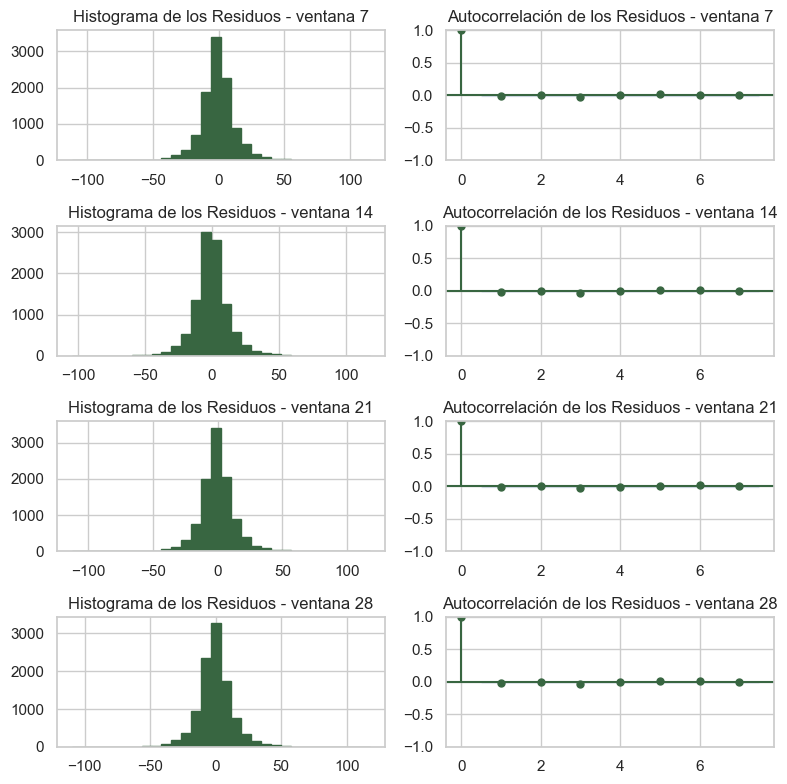

In [7]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(4, 2, figsize=(8, 8))  

for i, (k, datos) in enumerate(Random.items()):
    residuo = datos["residuos"]
    ax_hist = axes[i, 0]  
    ax_acf = axes[i, 1]   

    ax_hist.hist(residuo, bins=30, color='#386641', edgecolor='#386641')
    ax_hist.set_title(f"Histograma de los Residuos - ventana {int(k/24)}")
    ax_hist.set_xlabel("")
    ax_hist.set_ylabel("")

    sm.graphics.tsa.plot_acf(residuo, lags=7, ax=ax_acf, color='#386641', vlines_kwargs={'color': '#386641'}, alpha=0.05)
    ax_acf.set_title(f"Autocorrelación de los Residuos - ventana {int(k/24)}")

plt.tight_layout()
plt.show()

En las gráficas anteriores podemos ver los histogramas y autocorrelaciones para los residuos del modelo, aunque parecen seguir una distribución normal, sabemos que la prueba analítica arrojó que no se cumple el supuesto de normalidad y en las autocorrelaciones se puede ver un ligero patrón lo que evidencia la correlacion que existe entre ellos. 

Veamos como es el rendimiento del modelo al hacer las predicciones en el conjunto de test.

### **Predicciones en el test**

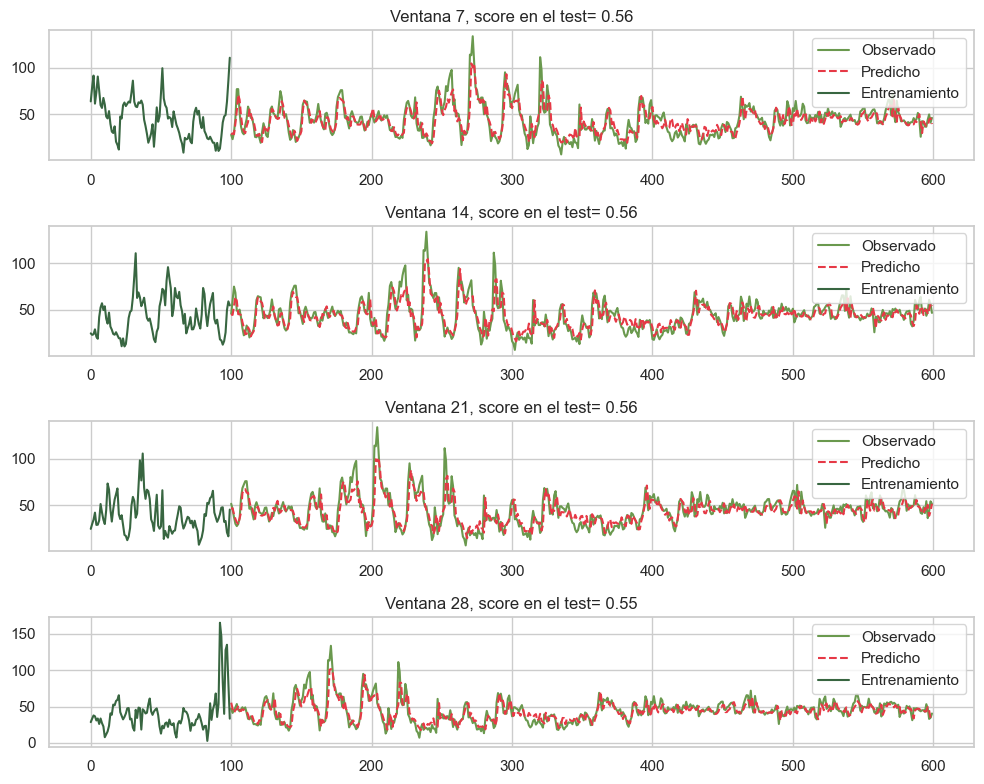

In [8]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(4, 1, figsize=(10,8))

for i, (k, datos) in enumerate(Random.items()):
    obs = datos["observado"][:500]
    predic = datos["predicc"][:500]
    yTrain = datos["entrenamiento y"]
    scsoreTest=datos['score test']
    ytrain=yTrain[-100:]

    ax = axes[i]
    sns.lineplot(x=range(len(ytrain), len(ytrain) + len(obs)), y=obs, label=f"Observado", color='#6a994e', ax=ax)
    sns.lineplot(x=range(len(ytrain), len(ytrain) + len(predic)), y=predic, label=f"Predicho", color="#e63946", linestyle="--", ax=ax)
    sns.lineplot(x=range(len(ytrain)), y=ytrain, label="Entrenamiento", color="#386641", ax=ax)
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"Ventana {int(k/24)}, score en el test= {round(scsoreTest,2)}")
    ax.legend()

plt.tight_layout()
plt.show()

## **XGBoost**

En segundo lugar se evaluará el rendimiento que tendrá el modelo XGBoost Regresor en nuestro conjunto de datos.

In [ ]:
resultados_xgboost = {}
for i in [7*24,14*24,21*24,28*24]:
    nb_timesteps = i
    X, y = makeXy(data_pm10['pm10'], nb_timesteps)

    train_size = int(len(X) * 0.6) 
    val_size = int(len(X) * 0.2)    

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    param_grid = {
        'n_estimators': [50, 100, 150],        
        'learning_rate': [0.01, 0.1, 0.2],    
        'max_depth': [3, 5, 7]              
    }

    best_score = -np.inf
    best_params = None
    best_model_xgb = None
    print(f"ventana{int(i/24)}")

    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            for max_depth in param_grid['max_depth']:
                
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('xgboost', XGBRegressor(
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        tree_method='gpu_hist',
                        random_state=42
                    ))
                ])

                pipeline.fit(X_train, y_train)

                y_val_pred = pipeline.predict(X_val)
                score = r2_score(y_val, y_val_pred)

                if score > best_score:
                    best_score = score
                    best_params = {
                        'n_estimators': n_estimators,
                        'learning_rate': learning_rate,
                        'max_depth': max_depth
                    }
                    best_model_xgb = pipeline


    y_test_pred = best_model_xgb.predict(X_test)

    # Almacenar los resultados
    resultados_xgboost[i] = {
        'parametros': best_params,
        'score val': best_score,
        'score test': r2_score(y_test, y_test_pred),
        'residuos': y_test - y_test_pred,
        'predicc': y_test_pred,
        'modelo': best_model_xgb,
        'entrenamiento y': y_train,
        'observado': y_test
    }


ventana7
ventana14
ventana21
ventana28


In [9]:
with open('resultados_XGB.pkl', 'rb') as f:
    resultados_xgboost = pickle.load(f)

### **Errores y métricas**

In [10]:
tabla2 = pd.DataFrame()

for clave, valor in resultados_xgboost.items():
    real = valor['observado']
    predic = valor['predicc']
    residuos=valor['residuos']
    r2=valor['score test']
    parametro=valor['parametros']
    
    # Calcular las métricas
    mae = mean_absolute_error(real, predic)
    mse = mean_squared_error(real, predic)
    rmse = np.sqrt(mse)

    ljung_box_results = acorr_ljungbox(residuos, lags=[10], return_df=True)
    
    jb_stat, jb_pvalue = jarque_bera(residuos)
    
    tabla_temp = pd.DataFrame({
        'Ventana': [int(clave/24)],
        'parametro': [parametro],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse],
        'R2': [r2],
        'Ljung-Box p-value': [ljung_box_results['lb_pvalue'].values[0]],
        'Jarque-Bera p-value': [jb_pvalue]
    })
    
    tabla2 = pd.concat([tabla2, tabla_temp], ignore_index=True)

# Mostrar el DataFrame final
tabla2

,Ventana,parametro,MAE,MSE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,7,"{'n_estimators': 150, 'learning_rate': 0.1, 'm...",9.318599,176.468969,13.284162,0.561280,0.002533,0.0
1,14,"{'n_estimators': 150, 'learning_rate': 0.1, 'm...",9.330692,176.002132,13.266580,0.563026,0.006831,0.0
2,21,"{'n_estimators': 150, 'learning_rate': 0.1, 'm...",9.345935,175.613050,13.251907,0.564745,0.058421,0.0
3,28,"{'n_estimators': 150, 'learning_rate': 0.1, 'm...",9.370624,175.875436,13.261804,0.564946,0.070654,0.0


En la tabla anterior se muestran los resultados para cada una de las ventanas, vemos que en general las métricas no varían en cada una de las ventanas, el promedio del score en el test es de 56%, lo único diferencial se encuentra al comparar los resultados de las pruebas analíticas para comprobar la independencia de los residuos, este supuesto solo se cumple para la ventana de 21 y 28 días, el score mayor se encuentra en la ventana de 28.

#### **Gráfica para los supuestos**

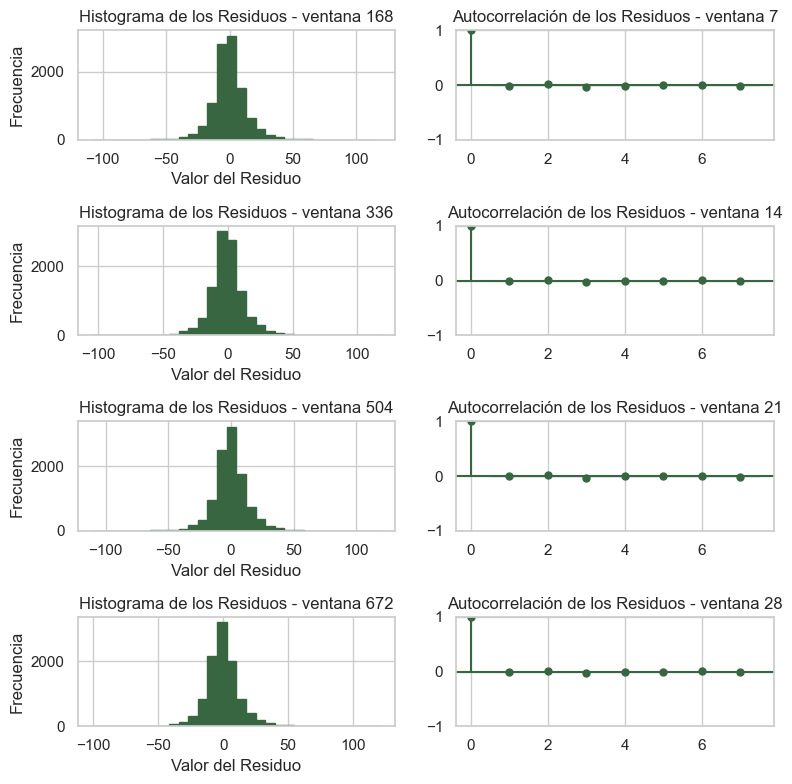

In [11]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(4, 2, figsize=(8, 8))  

for i, (k, datos) in enumerate(resultados_xgboost.items()):
    residuo = datos["residuos"]
    ax_hist = axes[i, 0]  
    ax_acf = axes[i, 1]   

    ax_hist.hist(residuo, bins=30, color='#386641', edgecolor='#386641')
    ax_hist.set_title(f"Histograma de los Residuos - ventana {k}")
    ax_hist.set_xlabel("Valor del Residuo")
    ax_hist.set_ylabel("Frecuencia")

    sm.graphics.tsa.plot_acf(residuo, lags=7, ax=ax_acf, color='#386641', vlines_kwargs={'color': '#386641'}, alpha=0.05)
    ax_acf.set_title(f"Autocorrelación de los Residuos - ventana {int(k/24)}")

plt.tight_layout()
plt.show()

### **Predicción en el conjunto de test**

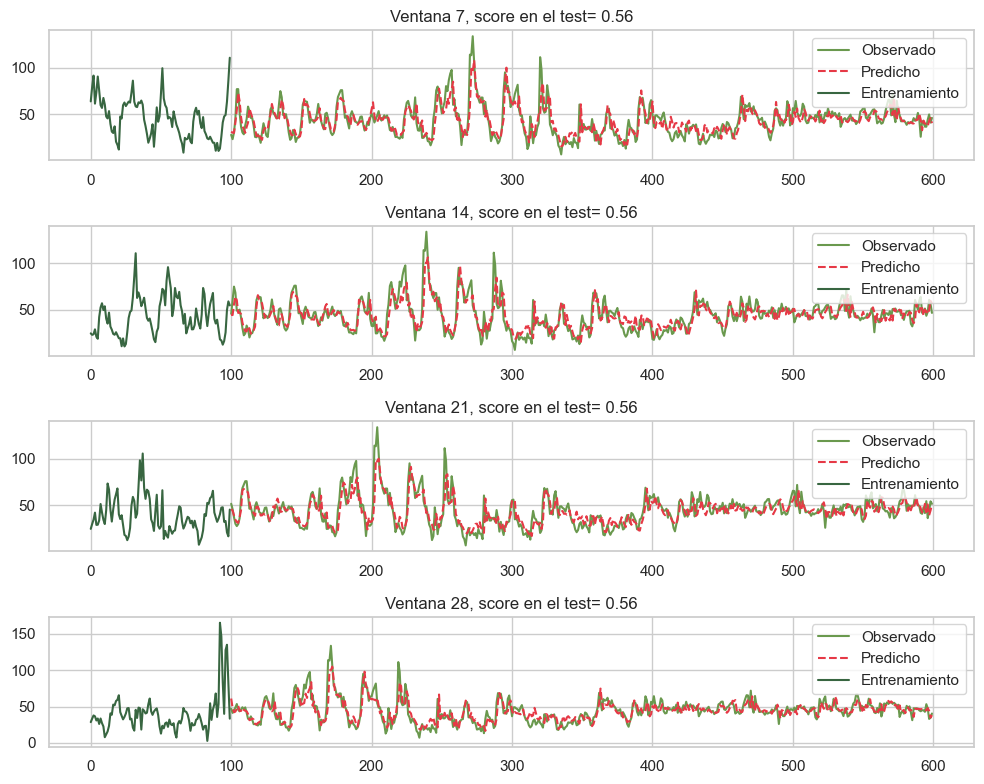

In [12]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(4, 1, figsize=(10,8))

for i, (k, datos) in enumerate(resultados_xgboost.items()):
    obs = datos["observado"][:500]
    predic = datos["predicc"][:500]
    yTrain = datos["entrenamiento y"]
    scsoreTest=datos['score test']
    ytrain=yTrain[-100:]

    ax = axes[i]
    sns.lineplot(x=range(len(ytrain), len(ytrain) + len(obs)), y=obs, label=f"Observado", color='#6a994e', ax=ax)
    sns.lineplot(x=range(len(ytrain), len(ytrain) + len(predic)), y=predic, label=f"Predicho", color="#e63946", linestyle="--", ax=ax)
    sns.lineplot(x=range(len(ytrain)), y=ytrain, label="Entrenamiento", color="#386641", ax=ax)
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"Ventana {int(k/24)}, score en el test= {round(scsoreTest,2)}")
    ax.legend()

plt.tight_layout()
plt.show()

## **SVR**

Veamos el comportamiento del modelo SVR en nuetros datos de PM10.

In [ ]:
resultados_svr = {}
for i in [7 * 24, 14 * 24, 21 * 24, 28 * 24]:
    nb_timesteps = i
    X, y = makeXy(data_pm10['pm10'], nb_timesteps)

    train_size = int(len(X) * 0.6)  
    val_size = int(len(X) * 0.2)    

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    param_grid = {
        'C': [0.1, 1, 10],          
        'gamma': [ 0.01, 0.1, 1],   
    }

    best_score = -np.inf
    best_params = None
    best_model_svr = None
    print(f"ventana {int(i/24)}")

    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            
            pipeline = Pipeline([
                ('scaler', StandardScaler()),       
                ('svr', SVR(kernel='rbf', C=C, gamma=gamma))  
            ])

            pipeline.fit(X_train, y_train)

            y_val_pred = pipeline.predict(X_val)
            score = r2_score(y_val, y_val_pred)

            if score > best_score:
                best_score = score
                best_params = {
                    'C': C,
                    'gamma': gamma
                }
                best_model_svr = pipeline

    y_test_pred = best_model_svr.predict(X_test)

    resultados_svr[i] = {
        'parametros': best_params,
        'score val': best_score,
        'score test': r2_score(y_test, y_test_pred),
        'residuos': y_test - y_test_pred,
        'predicc': y_test_pred,
        'modelo': best_model_svr,
        'entrenamiento y': y_train,
        'observado': y_test
    }


In [13]:
with open('resultados_SVR.pkl', 'rb') as f:
    SVR_result = pickle.load(f)

### **Errores y métricas**

In [14]:
tabla3 = pd.DataFrame()

for clave, valor in SVR_result.items():
    real = valor['observado']
    predic = valor['predicc']
    residuos=valor['residuos']
    r2=valor['score test']
    parametro=valor['parametros']
    
    # Calcular las métricas
    mae = mean_absolute_error(real, predic)
    mse = mean_squared_error(real, predic)
    rmse = np.sqrt(mse)

    ljung_box_results = acorr_ljungbox(residuos, lags=[10], return_df=True)
    
    jb_stat, jb_pvalue = jarque_bera(residuos)
    
    tabla_temp = pd.DataFrame({
        'Ventana': [int(clave/24)],
        'parametro': [parametro],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse],
        'R2': [r2],
        'Ljung-Box p-value': [ljung_box_results['lb_pvalue'].values[0]],
        'Jarque-Bera p-value': [jb_pvalue]
    })
    
    tabla3 = pd.concat([tabla3, tabla_temp], ignore_index=True)

tabla3

,Ventana,parametro,MAE,MSE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,7,"{'C': 10, 'gamma': 0.01}",9.490015,183.764379,13.555972,0.543143,1.421389e-83,0.0
1,14,"{'C': 10, 'gamma': 0.01}",11.250601,242.686750,15.578407,0.397463,0.000000e+00,0.0
2,21,"{'C': 10, 'gamma': 0.01}",13.192145,320.834728,17.911860,0.204815,0.000000e+00,0.0
3,28,"{'C': 10, 'gamma': 0.01}",13.587386,352.553435,18.776406,0.127907,0.000000e+00,0.0


Los resultados obtenidos para cada ventana muestran una tendencia clara de disminución en el rendimiento del modelo SVR a medida que aumenta el tamaño de la ventana. La ventana de 7 días presenta el mejor desempeño, con un R2 de 0.543 y valores relativamente bajos de error.  Además, los análisis de residuos indican la presencia de autocorrelación y no normalidad en todas las ventanas, lo que sugiere que el modelo subyacente podría no ser adecuado o que los datos requieren un preprocesamiento adicional.

#### **Gráficos de los supuestos**

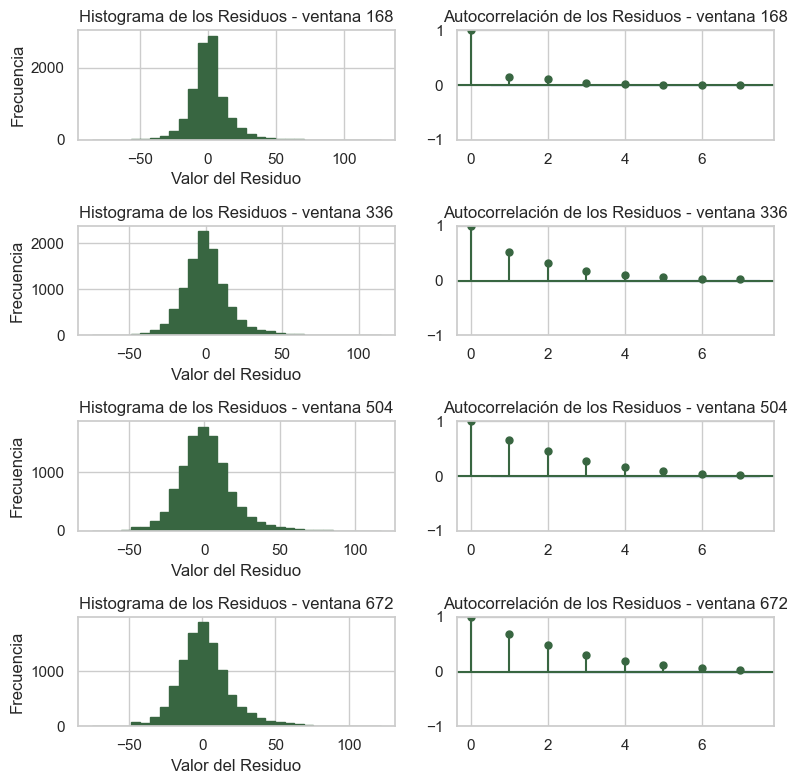

In [15]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(4, 2, figsize=(8, 8))  

for i, (k, datos) in enumerate(SVR_result.items()):
    residuo = datos["residuos"]
    ax_hist = axes[i, 0]  
    ax_acf = axes[i, 1]   

    ax_hist.hist(residuo, bins=30, color='#386641', edgecolor='#386641')
    ax_hist.set_title(f"Histograma de los Residuos - ventana {k}")
    ax_hist.set_xlabel("Valor del Residuo")
    ax_hist.set_ylabel("Frecuencia")

    sm.graphics.tsa.plot_acf(residuo, lags=7, ax=ax_acf, color='#386641', vlines_kwargs={'color': '#386641'}, alpha=0.05)
    ax_acf.set_title(f"Autocorrelación de los Residuos - ventana {k}")

plt.tight_layout()
plt.show()

En las gráficas anteriores podemos apreciar el de manera gráfica el comportamiento que tiene los residuos y es bastante evidente la correlación que hay entre los residuos lo que hace que este modelo no tiene un buen rendimiento para estos datos.

### **Predicciones en el test**

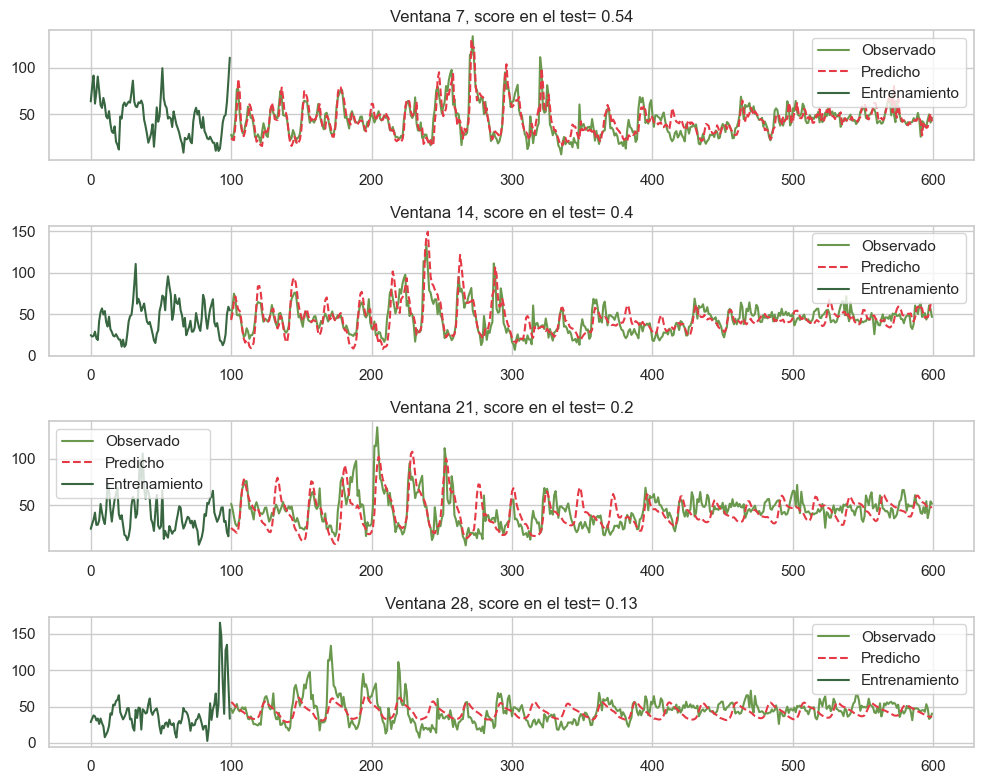

In [16]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(4, 1, figsize=(10,8))

for i, (k, datos) in enumerate(SVR_result.items()):
    obs = datos["observado"][:500]
    predic = datos["predicc"][:500]
    yTrain = datos["entrenamiento y"]
    scsoreTest=datos['score test']
    ytrain=yTrain[-100:]

    ax = axes[i]
    sns.lineplot(x=range(len(ytrain), len(ytrain) + len(obs)), y=obs, label=f"Observado", color='#6a994e', ax=ax)
    sns.lineplot(x=range(len(ytrain), len(ytrain) + len(predic)), y=predic, label=f"Predicho", color="#e63946", linestyle="--", ax=ax)
    sns.lineplot(x=range(len(ytrain)), y=ytrain, label="Entrenamiento", color="#386641", ax=ax)
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"Ventana {int(k/24)}, score en el test= {round(scsoreTest,2)}")
    ax.legend()

plt.tight_layout()
plt.show()

## **Hibrido XGBoost - SVR**

***Metodología:*** La implementación de este modelo hibrido cuenta con ciertos elementos que serán explicados a continuación:
1. Como modelo base se implemento un modelo XGBoost, el cual tiene la tarea de capturar patrones generales en los datos.

2. Luego del ajuste de nuestro modelo base es necesario calcular sus residuos, es decir aquel patrón que el modelo no puedo capturar, y es ahí donde entre el modelo secundario.

3. Como propuesta de modelo secundario se implemento una regresión de vectores de soporte el cual será entrenado con los residuos del modelo base.

4. Como paso final se obtiene la predicción del modelo hibrido que resulta en la combinación de la predicción del modelo base y la prediccion del modelos secundario.

Con estos aspectos claros podemos pasar a analizar los resultados que tuvo esta propuesta en la predicción de la partícula de PM10.

In [11]:
X, y = makeXy(data_pm10['pm10'], 28*24)

train_size = int(len(X) * 0.8)  

train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

In [ ]:
def hybrid_xgboost_svr_with_metrics(train_X, train_y, test_X, test_y):

    print(f'Ajustando el modelo XGB')
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42,tree_method='gpu_hist', predictor='gpu_predictor')
    xgb_model.fit(train_X, train_y)
    
    # Predicciones iniciales
    xgb_train_pred = xgb_model.predict(train_X)
    xgb_test_pred = xgb_model.predict(test_X)
    
    # Paso 2: Calcular residuos
    train_residuals = train_y - xgb_train_pred
    print(f'Ajustando el modelo SVR')
    # Paso 3: Ajustar el modelo SVR en los residuos
    svr_model = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.01)
    svr_model.fit(train_X, train_residuals)
    
    # Predicción de residuos para el conjunto de prueba
    svr_train_residuals_pred = svr_model.predict(train_X)
    svr_test_residuals_pred = svr_model.predict(test_X)
    
    # Paso 4: Combinar predicciones
    hybrid_train_pred = xgb_train_pred + svr_train_residuals_pred
    hybrid_test_pred = xgb_test_pred + svr_test_residuals_pred
    
    # Métricas del modelo híbrido
    train_rmse = np.sqrt(mean_squared_error(train_y, hybrid_train_pred))
    test_rmse = np.sqrt(mean_squared_error(test_y, hybrid_test_pred))
    train_r2 = r2_score(train_y, hybrid_train_pred)
    test_r2 = r2_score(test_y, hybrid_test_pred)
    
    print(f"RMSE de entrenamiento (híbrido): {train_rmse:.4f}")
    print(f"R² de entrenamiento (híbrido): {train_r2:.4f}")
    print(f"RMSE de prueba (híbrido): {test_rmse:.4f}")
    print(f"R² de prueba (híbrido): {test_r2:.4f}")
    
    # Paso 5: Prueba de autocorrelación (Ljung-Box)
    residuals_hybrid = test_y - hybrid_test_pred
    lb_test = acorr_ljungbox(residuals_hybrid, lags=[10], return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[0]
    
    print(f"Prueba de Ljung-Box (p-valor para residuos híbridos): {lb_pvalue:.4f}")
    if lb_pvalue > 0.05:
        print("No se detecta autocorrelación significativa en los residuos (p > 0.05).")
    else:
        print("Se detecta autocorrelación significativa en los residuos (p ≤ 0.05).")
    
    return hybrid_test_pred, residuals_hybrid


In [ ]:
hybrid_predictions, residuals = hybrid_xgboost_svr_with_metrics(train_X, train_y, test_X, test_y)

In [17]:
with open('resultados_hibrido_xgb_svr.pkl', 'rb') as f:
    hybrid = pickle.load(f)

### **Métricas y errores**

In [18]:
tabla4 = pd.DataFrame()

for clave, valor in hybrid.items():
    real = valor['observado']
    predic = valor['predicc']
    residuos=valor['residuos']
    r2=valor['score test']
    parametro={ 'XGB': ['n_estimators=100, learning_rate=0.1, max_depth=5'],
        'SVR': ['C=100,Gamma=0.01, epsilon=0.01']}
    
    # Calcular las métricas
    mae = mean_absolute_error(real, predic)
    mse = mean_squared_error(real, predic)
    rmse = np.sqrt(mse)

    ljung_box_results = acorr_ljungbox(residuos, lags=[10], return_df=True)
    
    jb_stat, jb_pvalue = jarque_bera(residuos)
    
    tabla_temp = pd.DataFrame({
        'parametro': [parametro],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse],
        'R2': [r2],
        'Ljung-Box p-value': [ljung_box_results['lb_pvalue'].values[0]],
        'Jarque-Bera p-value': [jb_pvalue]
    })
    
    tabla4 = pd.concat([tabla4, tabla_temp], ignore_index=True)

# Mostrar el DataFrame final
tabla4

,parametro,MAE,MSE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,"{'XGB': ['n_estimators=100, learning_rate=0.1,...",9.360237,174.816237,13.221809,0.567566,0.079449,0.0


En la tabla anterior se puede observar las metricas de error para el modelo híbrido, podemos notar que los errores son relativamente bajos, podemos mencionar que se obtuvi un RMSE de 13.22, si analizamos el coeficiente de determinacion del modelo, nos encontramos con $r^2$ moderado a pesar de que se esperaba un mejor rendimiento, vemos que se cumple el supuesto de independencia de los residuos, lo cual es un aspecto importante a resaltar.

#### **Graficas para los supuestos**

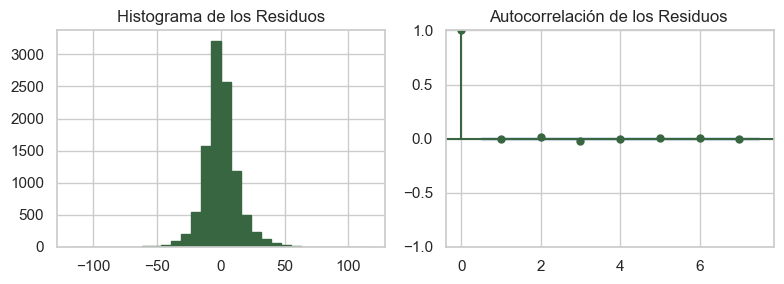

In [19]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(8, 3), squeeze=False)

for i, (k, datos) in enumerate(hybrid.items()):
    residuo = datos["residuos"]
    ax_hist = axes[i,0]  
    ax_acf = axes[i,1]   

    ax_hist.hist(residuo, bins=30, color='#386641', edgecolor='#386641')
    ax_hist.set_title(f"Histograma de los Residuos")
    ax_hist.set_xlabel("")
    ax_hist.set_ylabel("")

    sm.graphics.tsa.plot_acf(residuo, lags=7, ax=ax_acf, color='#386641', vlines_kwargs={'color': '#386641'}, alpha=0.05)
    ax_acf.set_title(f"Autocorrelación de los Residuos ")

plt.tight_layout()
plt.show()

### **Predicciones en el conjunto de test**

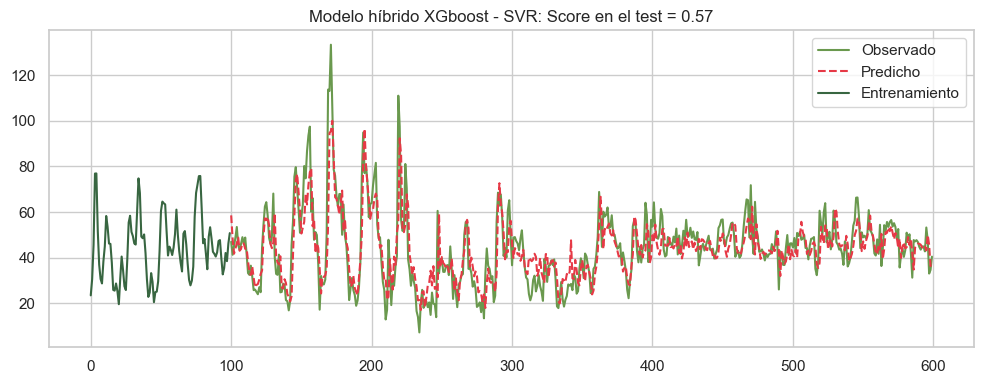

In [20]:
sns.set(style="whitegrid")

# Crear una figura y un solo eje
fig, ax = plt.subplots(figsize=(10, 4))

# Iterar sobre los elementos de Arima y graficar
for k, datos in hybrid.items():
    obs = datos["observado"][:500]
    predic = datos["predicc"][:500]
    scsoreTest = datos['score test']
    ytrain = datos['entrenamiento y'][-100:]

    # Graficar las líneas
    sns.lineplot(x=range(len(ytrain), len(ytrain) + len(obs)), y=obs, label=f"Observado", color='#6a994e', ax=ax)
    sns.lineplot(x=range(len(ytrain), len(ytrain) + len(predic)), y=predic, label=f"Predicho", color="#e63946", linestyle="--", ax=ax)
    sns.lineplot(x=range(len(ytrain)), y=ytrain, label="Entrenamiento", color="#386641", ax=ax)

    # Configurar título y etiquetas
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"Modelo híbrido XGboost - SVR: Score en el test = {round(scsoreTest, 2)}")
    ax.legend()

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

## **Conclusiones**

In [21]:
dataframes = [tabla1, tabla2, tabla3,tabla4]

rows_with_max_r2 = [df.loc[df['R2'].idxmax()] for df in dataframes]

df_max_r2 = pd.DataFrame(rows_with_max_r2)

df_max_r2.drop(columns=['Ventana'],inplace=True)
model=['Random Forest','XGBoost','SVR','Hibrido']
df_max_r2.insert(0, 'Modelo', model)
df_max_r2


,Modelo,parametro,MAE,MSE,RMSE,R2,Ljung-Box p-value,Jarque-Bera p-value
1,Random Forest,"{'n_estimators': 150, 'max_depth': 20}",9.340586,178.054768,13.343716,0.557930,2.430456e-04,0.0
3,XGBoost,"{'n_estimators': 150, 'learning_rate': 0.1, 'm...",9.370624,175.875436,13.261804,0.564946,7.065355e-02,0.0
0,SVR,"{'C': 10, 'gamma': 0.01}",9.490015,183.764379,13.555972,0.543143,1.421389e-83,0.0
0,Hibrido,"{'XGB': ['n_estimators=100, learning_rate=0.1,...",9.360237,174.816237,13.221809,0.567566,7.944937e-02,0.0


La tabla presenta un comparativo entre cuatro modelos: Random Forest, XGBoost, SVR y un modelo híbrido. El modelo híbrido, que combina XGBoost con el modelo de SVR, muestra un rendimiento ligeramente superior al resto en términos de R2, lo que indica una mejor capacidad para explicar la variabilidad en los datos. Ademas, el modelo híbrido cumple el supuesto de independencia en los residuos lo cual era lo esperado. A pesar del buen desempeño del modelo híbrido, sabemos que este puede mejorar, lo que nos da pie a que esta investigación continue en la busqueda de un modelo mas robusto que nos ayude a predecir la partícula de pm10, sabemos que al solucionar esta problemática podríamos ayudar a la prevención de daños causados por esta partícula contaminante, por lo cual nos motiva a continuar.